# AAS Project - Kubernetes Attack Cluster

descricao

## useful links

https://blog.palark.com/kubernetes-services-interaction-monitoring-with-netflow/

#### Imports


In [1]:
import pandas as pd
import hopsworks
import hsfs
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import glorot_normal

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

fg = fs.get_feature_group('benign_and_malicious_traffic_february', version=1)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/75925
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
#! na net da ua nao consigo ir buscar os dados à feature store, portanto tenho de os ir buscar localmente (:( firewall da ua so causa problemas)
data = pd.read_csv('data.csv')

#### Read data from Feature Store

In [3]:
data = fg.read()

Finished: Reading data from Hopsworks, using ArrowFlight (19.83s) 


### Get a small sample of data

In [4]:
data.head(-1)

,source_flow_id_encoded,source_flow_final,source_source_ip,source_destination_ip,source_network_bytes,source_network_transport,source_timestamp,source_event_duration,source_destination_port,source_source_port,label
0,19112,0,4027632609,4027632616,146,1,1645.796290,96539,31301.0,39648.0,malicious
1,17592,0,2130759677,2130759677,864,1,1645.797570,146480,9099.0,46044.0,benign
2,8518,1,905919982,3201805059,136,1,1645.796694,1002271678,22.0,29794.0,malicious
3,12452,1,905919982,3201763610,424,1,1645.794710,65542,9500.0,55286.0,benign
4,31811,1,4027662305,4027632616,68,1,1645.796694,0,31301.0,39481.0,malicious
...,...,...,...,...,...,...,...,...,...,...,...
47361,34036,1,4027662305,4027632616,136,1,1645.796694,1384311161,31301.0,59487.0,malicious
47362,32290,1,4027662305,4027632616,68,1,1645.796500,0,31301.0,55875.0,malicious
47363,7327,0,905919982,3201805059,220,1,1645.796270,1757666,22.0,60459.0,malicious
47364,1233,0,3201805056,901724183,547,2,1645.796180,34475304,53.0,51107.0,benign


In [5]:
data.describe()

,source_flow_id_encoded,source_flow_final,source_source_ip,source_destination_ip,source_network_bytes,source_network_transport,source_timestamp,source_event_duration,source_destination_port,source_source_port
count,47367.000000,47367.000000,4.736700e+04,4.736700e+04,4.736700e+04,47367.000000,47367.000000,4.736700e+04,47367.000000,47367.000000
mean,23683.000000,0.468026,-1.812046e+17,-1.812046e+17,1.763886e+05,1.074102,1645.796010,2.375082e+10,17907.334558,43939.324403
std,13673.819437,0.498982,8.705617e+17,8.705617e+17,1.182142e+07,0.261940,0.001294,3.693959e+11,14371.276207,13379.243218
min,0.000000,0.000000,-4.363558e+18,-4.363558e+18,5.600000e+01,1.000000,1645.791570,0.000000e+00,22.000000,22.000000
25%,11841.500000,0.000000,9.059200e+08,3.201768e+09,6.800000e+01,1.000000,1645.796010,0.000000e+00,3306.000000,38002.000000
50%,23683.000000,0.000000,3.201805e+09,3.201805e+09,1.720000e+02,1.000000,1645.796500,1.197990e+05,9500.000000,45864.000000
75%,35524.500000,1.000000,4.027662e+09,4.027633e+09,4.330000e+02,1.000000,1645.796694,2.522046e+06,31301.000000,53576.500000
max,47366.000000,1.000000,4.034741e+09,4.130921e+09,1.828469e+09,2.000000,1645.798160,6.601664e+12,65522.000000,65523.000000


## Data Visualization

#### Data Distribution

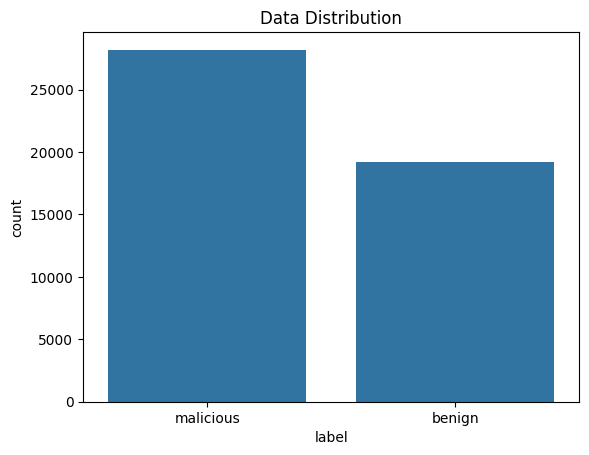

In [6]:
sns.countplot(x='label', data=data)
plt.title('Data Distribution')
plt.show()

#### 

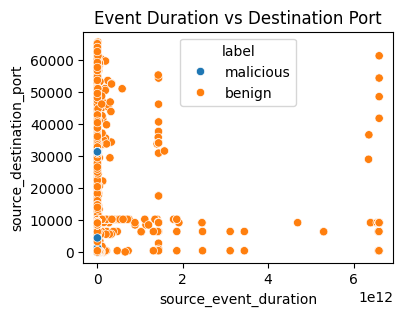

In [7]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='source_event_duration', y='source_destination_port', hue='label', data=data)
plt.title('Event Duration vs Destination Port')
plt.show()

##### With this plot (and the following) we can observate that malicious traffic tend to a small duration that the benign traffic.

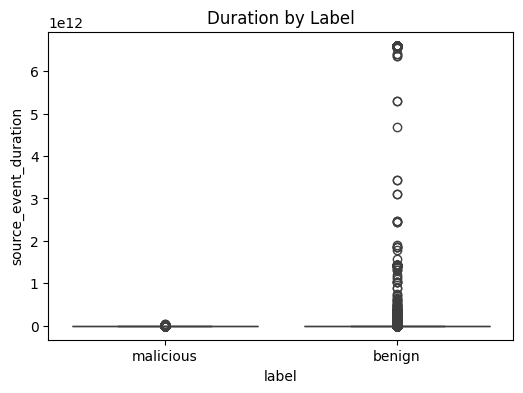

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='source_event_duration', data=data)
plt.title('Duration by Label')
plt.show()

#### Pair plot 

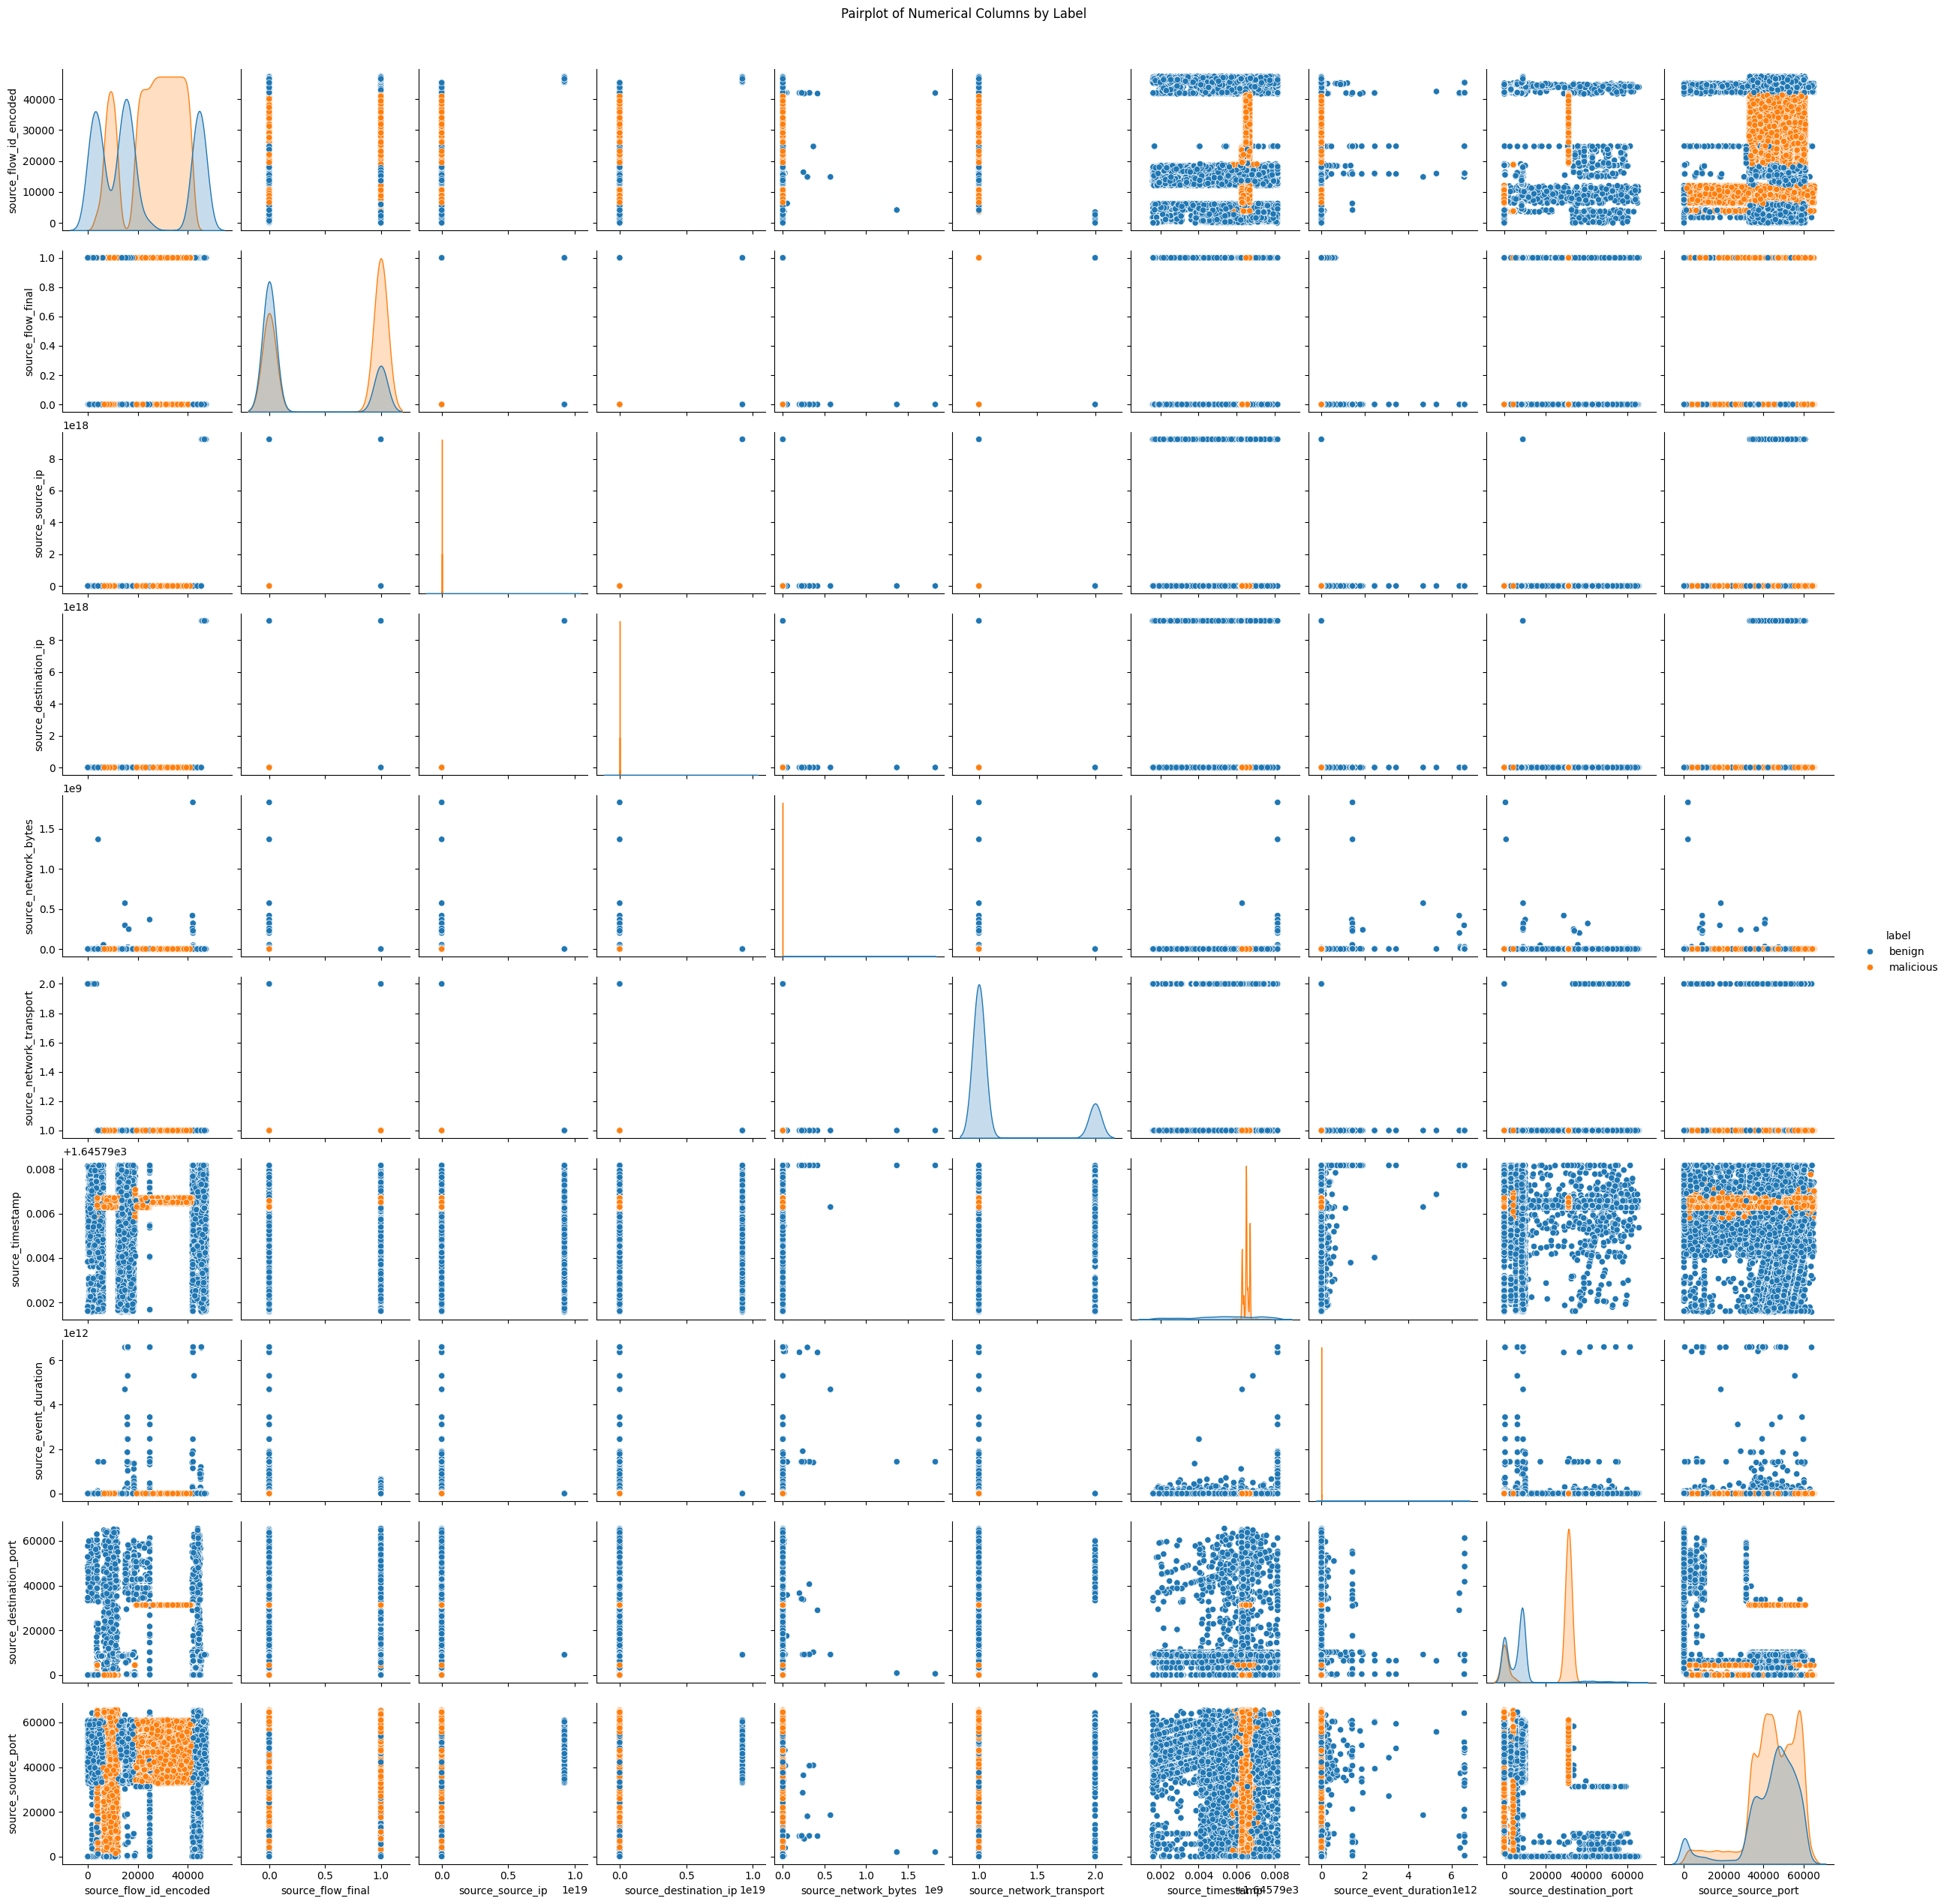

In [90]:
sns.pairplot(data, hue='label')
plt.suptitle('Pairplot of Numerical Columns by Label', y=1.02)
plt.show()

#### Histograms for each feature (hue = label)

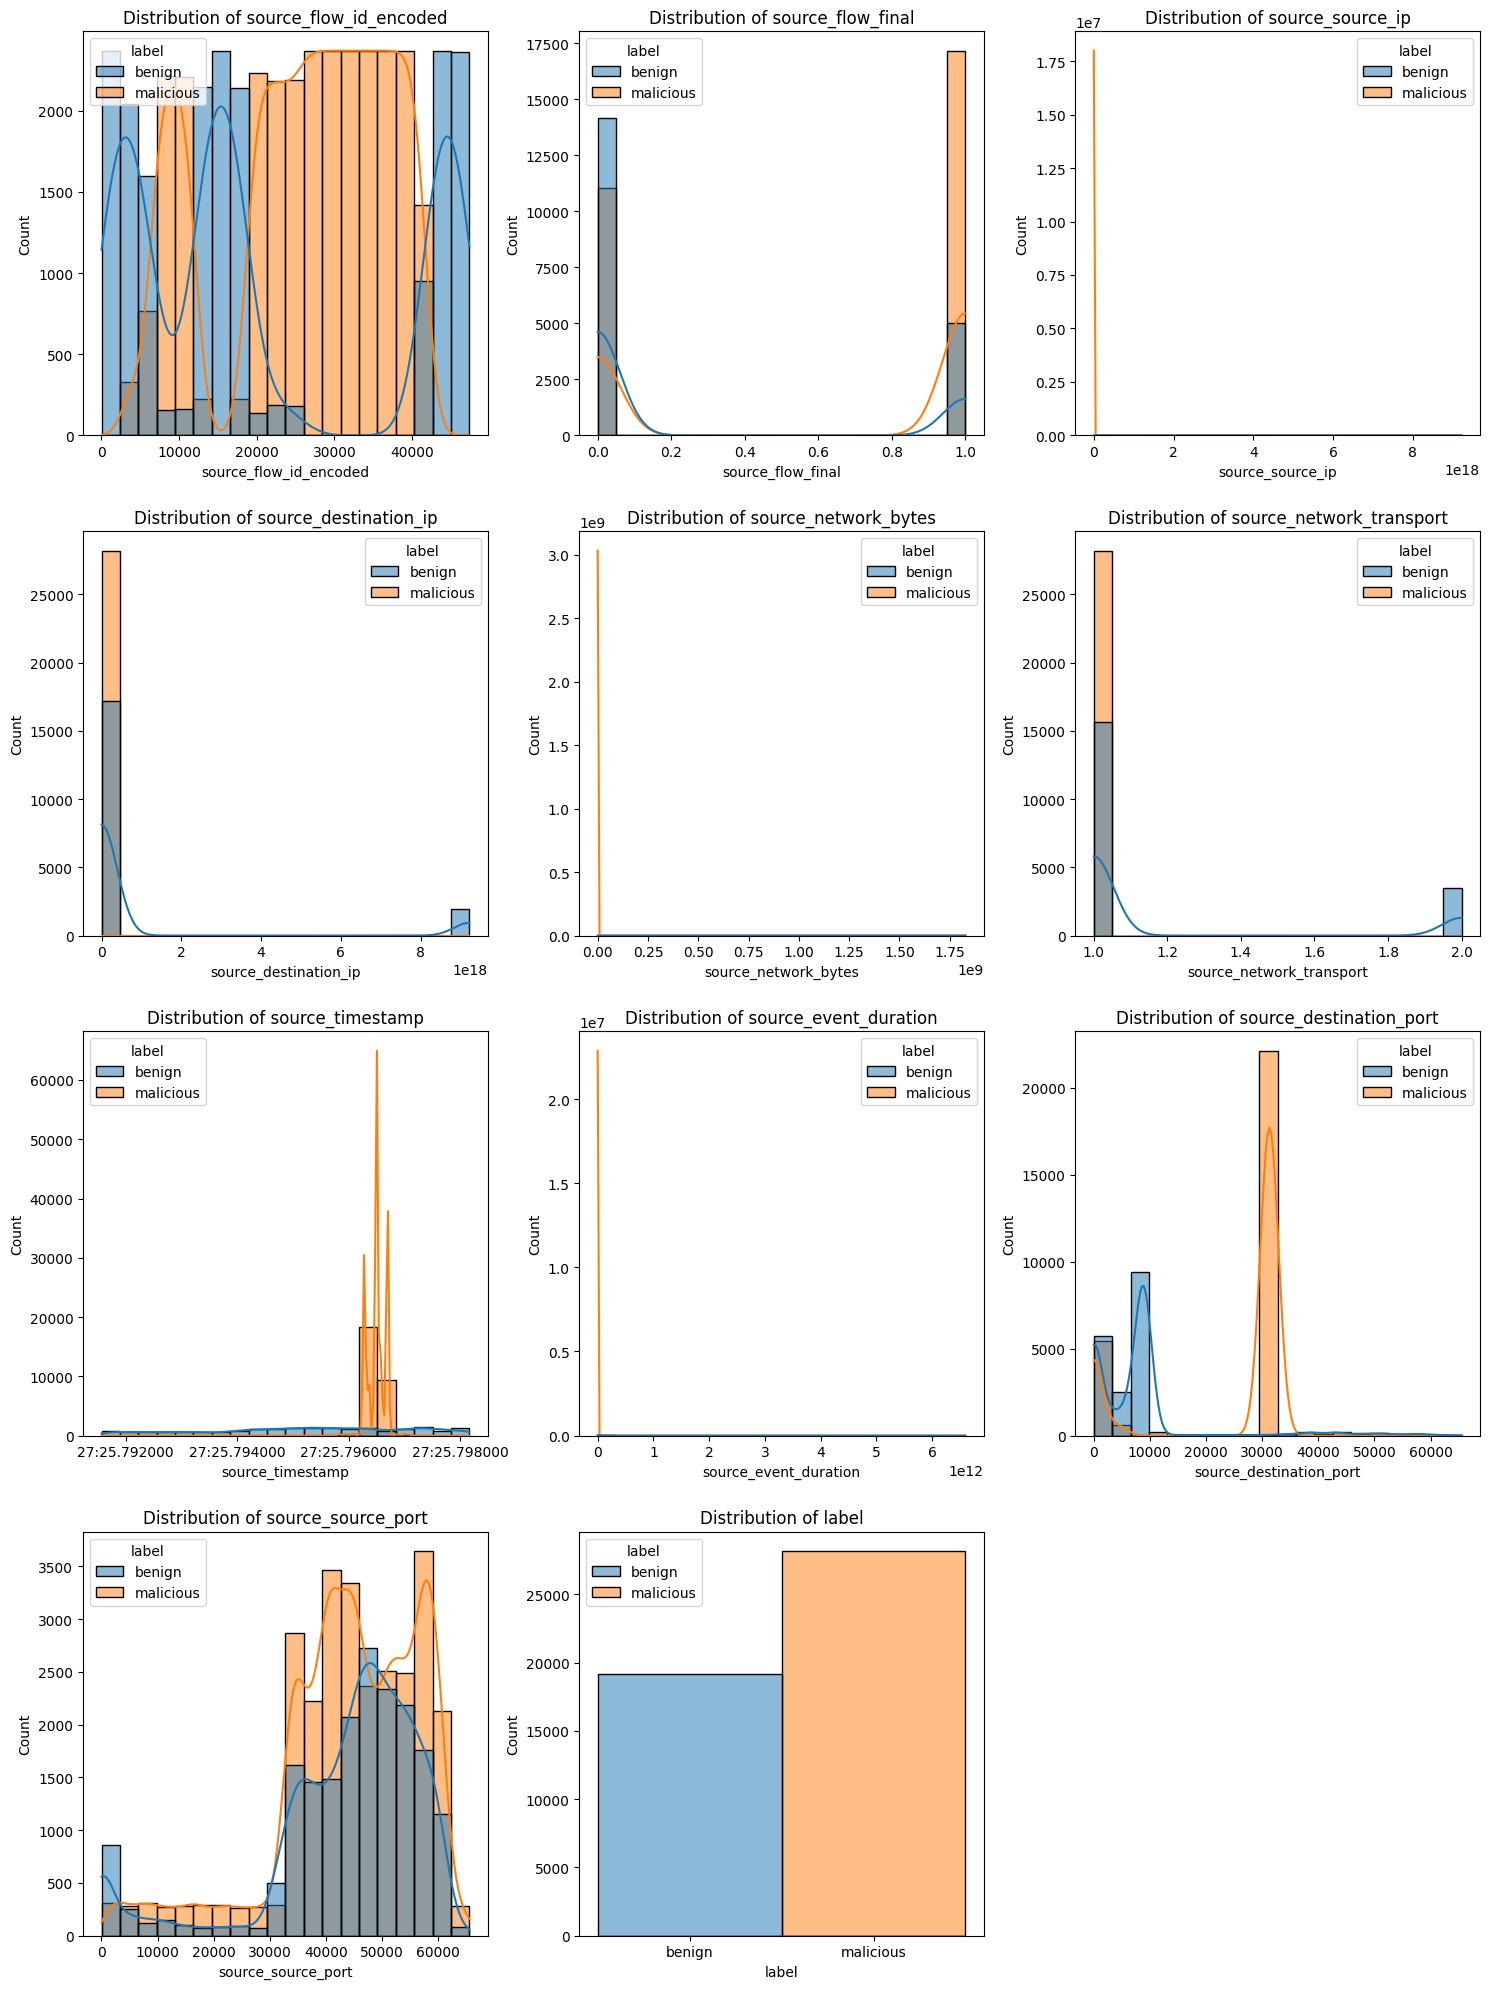

In [10]:
features = data.columns
n_rows = (len(features) + 2) // 3

fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(data=data, x=feature, hue='label', kde=True, bins=20, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')

for i in range(len(features), n_rows * 3):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

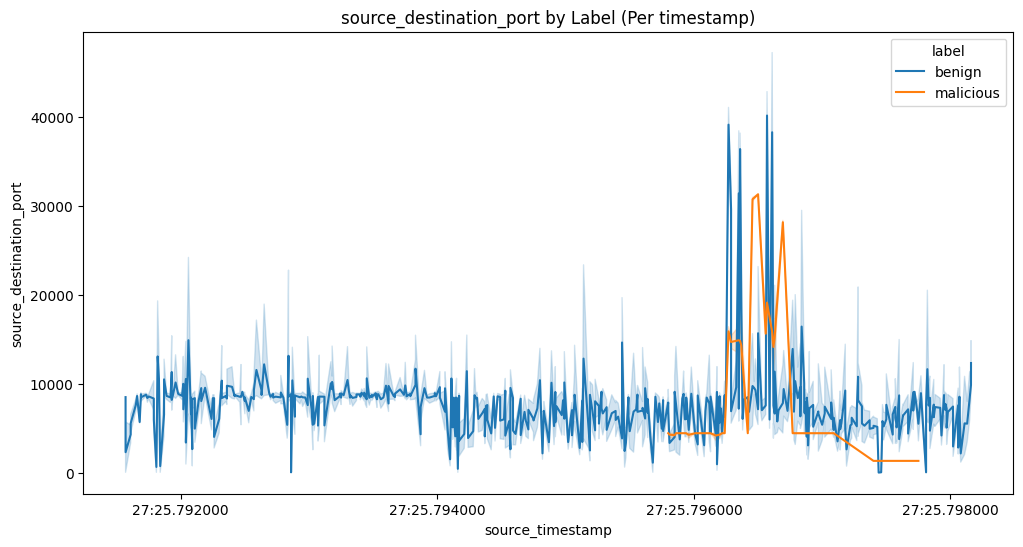

In [12]:
data['source_timestamp'] = pd.to_datetime(data['source_timestamp'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='source_timestamp', y='source_destination_port', hue='label', data=data)
plt.title('source_destination_port by Label (Per timestamp)')
plt.show()

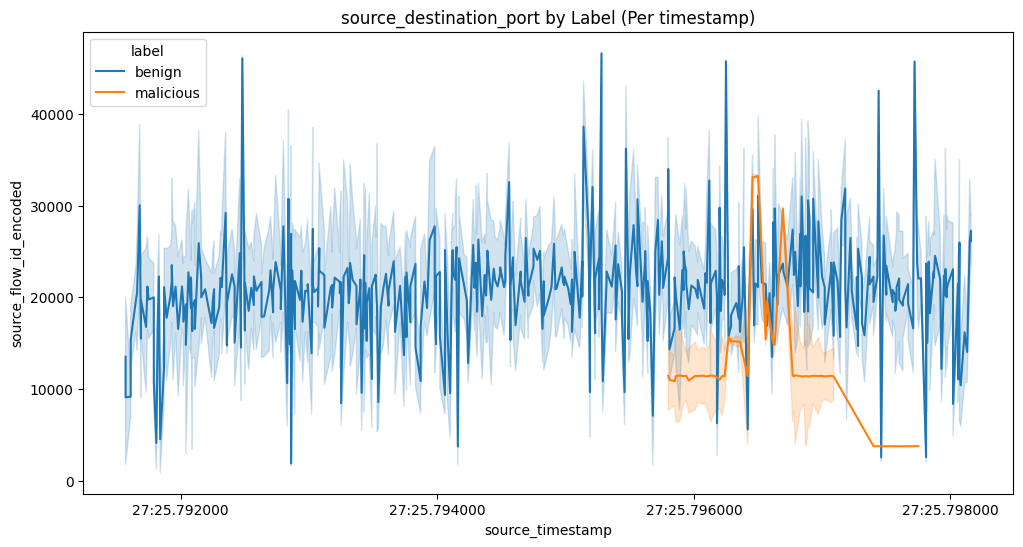

In [17]:
data['source_timestamp'] = pd.to_datetime(data['source_timestamp'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='source_timestamp', y='source_flow_id_encoded', hue='label', data=data)
plt.title('source_destination_port by Label (Per timestamp)')
plt.show()

In [9]:
fv = fs.get_feature_view('benign_and_malicious_traffic_february_view', version=1)

#### The data is split into train, validation and test sets, this was made in the pre-processing phase (folder feature-store in the root of the project)

In [38]:
x_train, x_test, _, y_train, y_test, __= fv.get_train_validation_test_split(training_dataset_version=3)

KeyboardInterrupt: 

### AutoEncoder

In [41]:
x_train_norm = x_train
x_test_norm = x_test

input_dim = x_train_norm.shape[1]
latent_dim = 6

tf.keras.utils.set_random_seed(42)

# Encoder
input_img = Input(shape=(input_dim,))
encoded = Dense(10, activation='swish', kernel_initializer=glorot_normal())(input_img)
encoded = Dense(8, activation='swish', kernel_initializer=glorot_normal())(encoded)
encoded = Dense(latent_dim, activation='relu', kernel_initializer=glorot_normal())(encoded)
encoder = Model(input_img, encoded)

# Decoder
decoder_input = Input(shape=(latent_dim,))
decoded_layer = Dense(8, activation='swish', kernel_initializer=glorot_normal())(decoder_input)
decoded_layer = Dense(10, activation='swish', kernel_initializer=glorot_normal())(decoded_layer)
decoded_layer = Dense(input_dim, activation='linear', kernel_initializer=glorot_normal())(decoded_layer)
decoder = Model(decoder_input, decoded_layer)

# Autoencoder
autoencoder_output = decoder(encoder(input_img))
autoencoder = Model(input_img, autoencoder_output)
autoencoder.compile(optimizer=Adam(), loss='mse')
history = autoencoder.fit(x_train_norm, x_train_norm, epochs=128, batch_size=512, shuffle=True, validation_data=(x_test_norm, x_test_norm))
encoder.compile(optimizer=Adam(), loss='mse')
encoded_train = encoder.predict(x_train_norm)
encoded_test = encoder.predict(x_test_norm)

Epoch 1/128
65/65 [==============================] - 0s 2ms/step - loss: 0.2719 - val_loss: 0.1520
Epoch 2/128
65/65 [==============================] - 0s 854us/step - loss: 0.0948 - val_loss: 0.0616
Epoch 3/128
65/65 [==============================] - 0s 800us/step - loss: 0.0550 - val_loss: 0.0516
Epoch 4/128
65/65 [==============================] - 0s 801us/step - loss: 0.0498 - val_loss: 0.0463
Epoch 5/128
65/65 [==============================] - 0s 789us/step - loss: 0.0415 - val_loss: 0.0339
Epoch 6/128
65/65 [==============================] - 0s 774us/step - loss: 0.0308 - val_loss: 0.0275
Epoch 7/128
65/65 [==============================] - 0s 791us/step - loss: 0.0273 - val_loss: 0.0258
Epoch 8/128
65/65 [==============================] - 0s 823us/step - loss: 0.0260 - val_loss: 0.0246
Epoch 9/128
65/65 [==============================] - 0s 781us/step - loss: 0.0245 - val_loss: 0.0227
Epoch 10/128
65/65 [==============================] - 0s 769us/step - loss: 0.0223 - val_loss

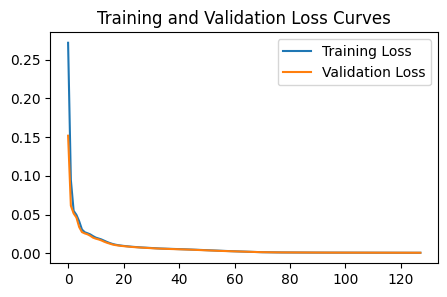

In [42]:
plt.figure(figsize=(5, 3))
plt.plot( history.history['loss'], label='Training Loss')
plt.plot( history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [43]:
encoded_train_df = pd.DataFrame(encoded_train, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6'])

In [44]:
encoded_train_df.head(-1)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0.038521,0.951169,0.000000,1.293370,0.310946,1.673398
1,0.129336,0.839034,0.000000,1.287770,0.509740,1.618315
2,1.862055,0.000000,0.000000,0.000000,4.594633,2.241623
3,1.814138,0.000000,0.000000,0.000000,4.536824,2.248365
4,0.085741,0.952422,0.000000,1.326023,0.306944,1.611137
...,...,...,...,...,...,...
33055,1.055219,0.000000,0.937695,0.000000,1.433500,0.000000
33056,0.237866,0.000000,0.770464,0.014528,0.000000,0.000000
33057,0.388395,0.000000,0.950235,0.028770,0.000000,0.000000
33058,0.635600,0.000000,1.211619,0.048590,0.000000,0.000000


#### Using the latent space data from autoencoder to train a classifier

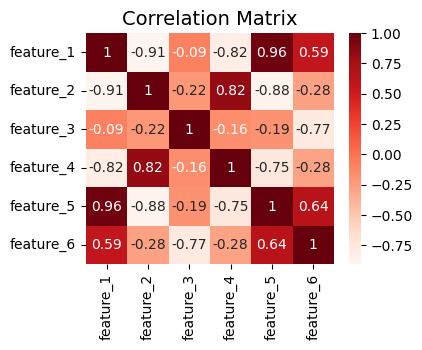

In [45]:
corr = encoded_train_df.corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

#### Init Models

In [46]:
svc = SVC(random_state=42)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)

pipeline_svc = Pipeline(steps=[('classifier', svc)])
pipeline_lr = Pipeline(steps=[('classifier', lr)])
pipeline_knn = Pipeline(steps=[('classifier', knn)])
pipeline_dt = Pipeline(steps=[('classifier', dt)])

#### Select hyperparameters search for each model

In [51]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [52]:
model_grids = [
    (pipeline_svc, param_grid_svc, 'SVM'),
    (pipeline_lr, param_grid_lr, 'Logistic Regression'),
    (pipeline_knn, param_grid_knn, 'K-Nearest Neighbors'),
    (pipeline_dt, param_grid_dt, 'Decision Tree')
]

results = {
    "Model": [],
    "Default Accuracy": [],
    "Best Accuracy": [],
    "Best Parameters": []
}

### Train models with default and hyperparameters search and plot results and confusion matrix


SVM Evaluation:
Default parameters accuracy: 0.8831932773109243

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.72      0.83      1911
   Malicious       0.84      0.99      0.91      2849

    accuracy                           0.88      4760
   macro avg       0.91      0.86      0.87      4760
weighted avg       0.90      0.88      0.88      4760



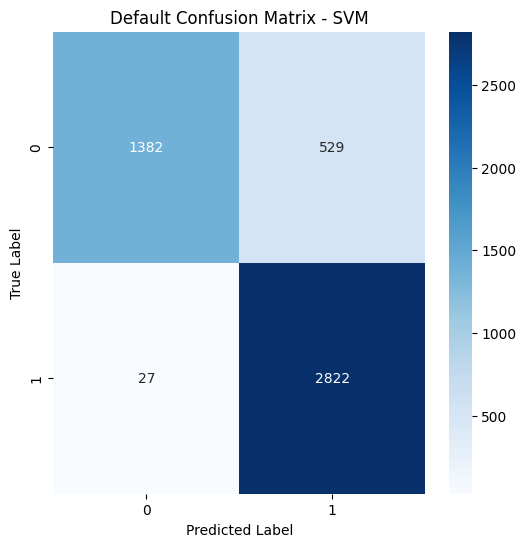

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/

Default parameters accuracy: 0.8869747899159663

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.73      0.84      1911
   Malicious       0.85      0.99      0.91      2849

    accuracy                           0.89      4760
   macro avg       0.91      0.86      0.88      4760
weighted avg       0.90      0.89      0.88      4760



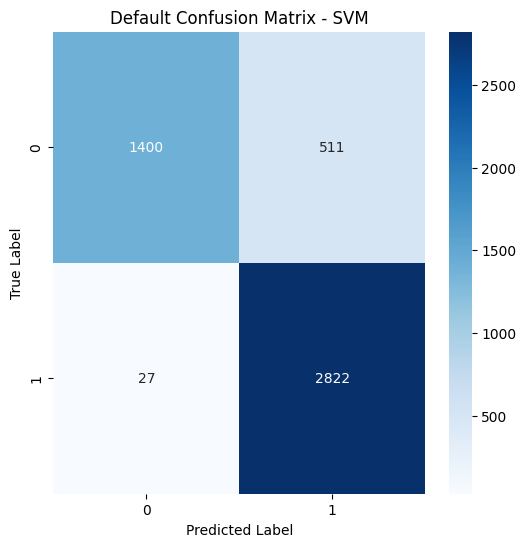


Logistic Regression Evaluation:
Default parameters accuracy: 0.7668067226890757

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.73      0.71      1911
   Malicious       0.81      0.79      0.80      2849

    accuracy                           0.77      4760
   macro avg       0.76      0.76      0.76      4760
weighted avg       0.77      0.77      0.77      4760



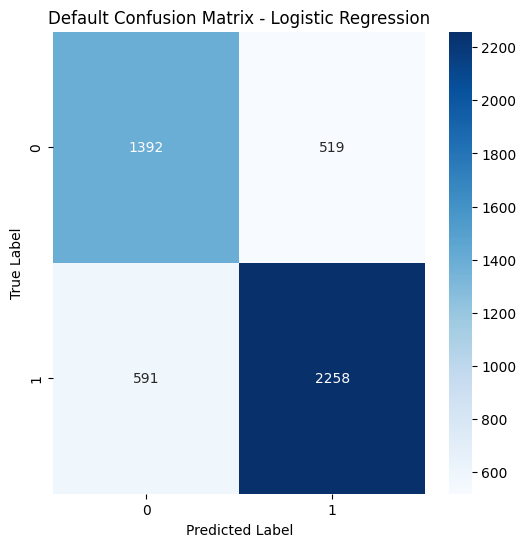

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/

Default parameters accuracy: 0.7626050420168067

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.72      0.71      1911
   Malicious       0.81      0.79      0.80      2849

    accuracy                           0.76      4760
   macro avg       0.75      0.76      0.75      4760
weighted avg       0.76      0.76      0.76      4760



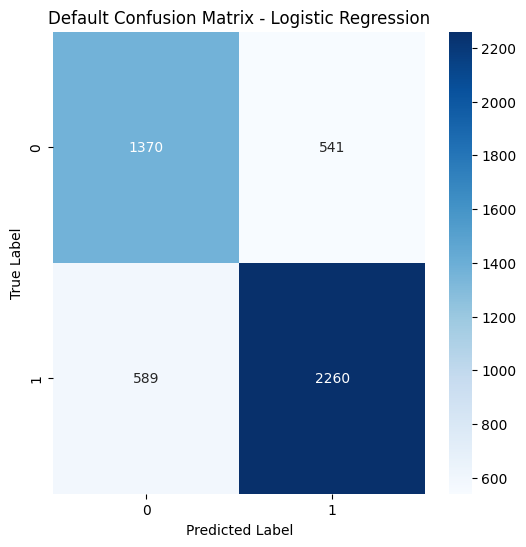


K-Nearest Neighbors Evaluation:
Default parameters accuracy: 0.9972689075630252

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



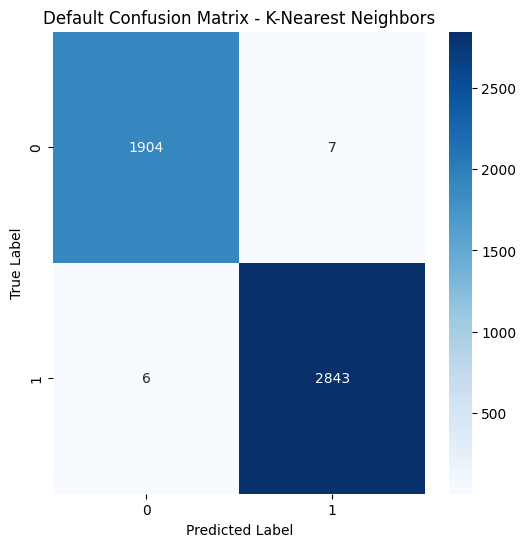

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas

Default parameters accuracy: 0.9978991596638656

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



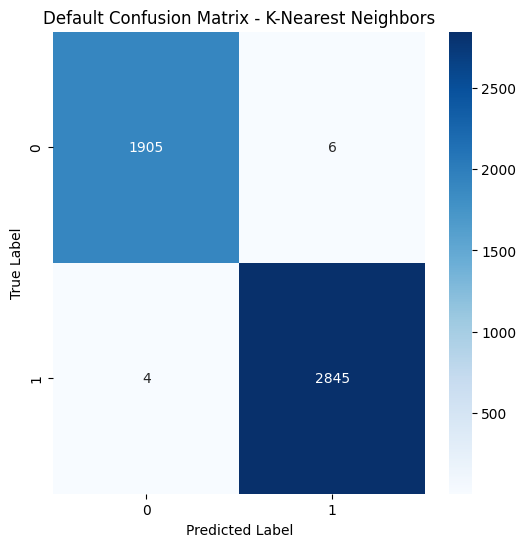


Decision Tree Evaluation:
Default parameters accuracy: 0.9951680672268908

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      0.99      0.99      4760
weighted avg       1.00      1.00      1.00      4760



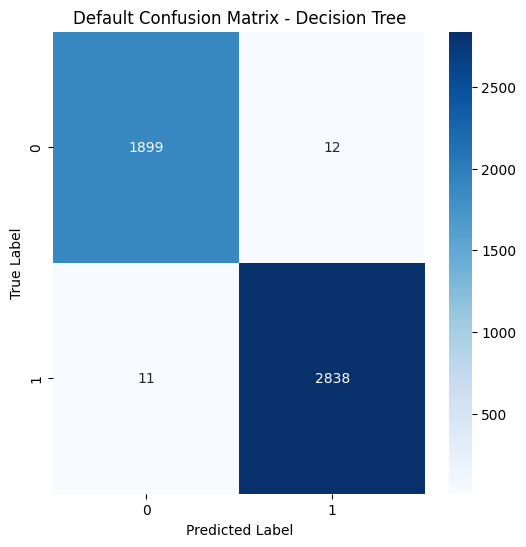

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Default parameters accuracy: 0.9949579831932773

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99      1911
   Malicious       1.00      0.99      1.00      2849

    accuracy                           0.99      4760
   macro avg       0.99      1.00      0.99      4760
weighted avg       0.99      0.99      0.99      4760



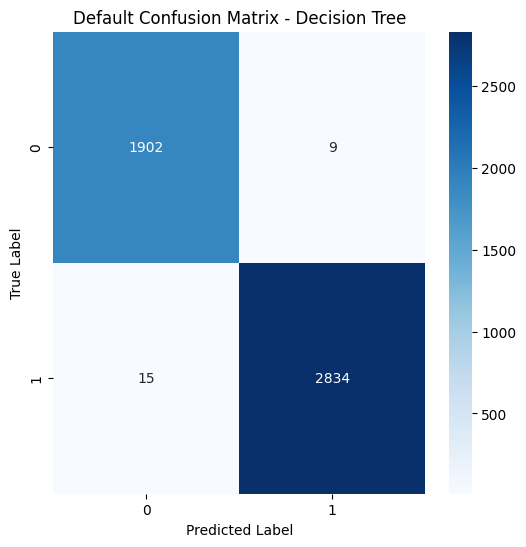

In [53]:
def conf_matrix(y_test, y_pred, name):
    cm_default = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Default Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def print_results(default_accuracy, y_pred_default, y_test):
    print(f"Default parameters accuracy: {default_accuracy}")
    print("\nDefault Parameter Classification Report:")
    print(classification_report(y_test, y_pred_default, target_names=['Benign', 'Malicious']))

for pipeline, param_grid, name in model_grids:
    print(f"\n{name} Evaluation:")

    pipeline.fit(encoded_train_df, y_train)
    y_pred_default = pipeline.predict(encoded_test)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    print_results(default_accuracy, y_pred_default, y_test)

    #confusion Matrix for default parameters
    conf_matrix(y_test, y_pred_default, name)

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(encoded_train_df, y_train)

    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(encoded_test)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    print_results(best_accuracy, y_pred_best, y_test)

    #confusion Matrix for Grid Search Parameters
    conf_matrix(y_test, y_pred_best, name)

    results["Model"].append(name)
    results["Default Accuracy"].append(default_accuracy)
    results["Best Accuracy"].append(best_accuracy)
    results["Best Parameters"].append(grid_search.best_params_)


### Results

In [59]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', 200)

results_df

,Model,Default Accuracy,Best Accuracy,Best Parameters
0,SVM,0.883193,0.886975,"{'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}"
1,Logistic Regression,0.766807,0.762605,"{'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}"
2,K-Nearest Neighbors,0.997269,0.997899,"{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}"
3,Decision Tree,0.995168,0.994958,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2}"
